# ON & OFF zones notebook 

In [1]:
#Imports 

import numpy as np
from numpy import random
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from scipy import interpolate
import sys 
from re import search
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude
import glob
from datetime import datetime

In [2]:
#Root directory of the 4LAC-RD2 catalogue 
fits_image_filename_1 = 'C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/table-4LAC-DR2-h.fits'
fits_image_filename_2 = 'C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/table-4LAC-DR2-l.fits'

#Import data
HighLAT = fits.getdata(fits_image_filename_1) #  np.ndarray
LowLAT = fits.getdata(fits_image_filename_2)
header = fits.getheader(fits_image_filename_1)
header2=fits.getheader(fits_image_filename_2)

#Opening data
hdul = fits.open(fits_image_filename_1)
hdul2 = fits.open(fits_image_filename_2)

#Get names of all sources in the catalogue
NamesH=np.array(HighLAT["Source_Name"])
NamesL=np.array(LowLAT["Source_Name"])

In [3]:
#Root directoy of all raw light curves
path_of_the_directory= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/LCs/"

data_files = []
file_names = []

#Root directory to later save OFF & ON time seriesonce  the list of OFF & ON sources is made
Saving_Folder_adress= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/"

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,filename)
    if os.path.isfile(f):
        data_files.append(f)
        file_names.append(filename)
        
                              
Source_names=file_names.copy()

#Changing the names of data files and removing strings - to find matches between available data and the 4LAC-DR2 catalogue
for i in range(len(file_names)): 
    
    Source_names[i]=Source_names[i].replace('.csv','')
    Source_names[i]=Source_names[i].replace('.txt','')
    Source_names[i]=Source_names[i].replace('LC_4FGL','4FGL ')
    Source_names[i]=Source_names[i].replace('LC_4FGL','4FGL ')

NamesH=HighLAT["Source_Name"]
NamesL=LowLAT["Source_Name"]

for i in range(len(NamesH)):
    
    NamesH[i]=NamesH[i].replace('.0','')
    NamesH[i]=NamesH[i].replace('.1','')
    NamesH[i]=NamesH[i].replace('.2','')
    NamesH[i]=NamesH[i].replace('.3','')
    NamesH[i]=NamesH[i].replace('.4','')
    NamesH[i]=NamesH[i].replace('.5','')
    NamesH[i]=NamesH[i].replace('.6','')
    NamesH[i]=NamesH[i].replace('.7','')
    NamesH[i]=NamesH[i].replace('.8','')
    NamesH[i]=NamesH[i].replace('.9','')
    
for i in range(len(NamesL)):
    
    NamesL[i]=NamesL[i].replace('.0','')
    NamesL[i]=NamesL[i].replace('.1','')
    NamesL[i]=NamesL[i].replace('.2','')
    NamesL[i]=NamesL[i].replace('.3','')
    NamesL[i]=NamesL[i].replace('.4','')
    NamesL[i]=NamesL[i].replace('.5','')
    NamesL[i]=NamesL[i].replace('.6','')
    NamesL[i]=NamesL[i].replace('.7','')
    NamesL[i]=NamesL[i].replace('.8','')
    NamesL[i]=NamesL[i].replace('.9','')
    
NamesH = np.array(NamesH.reshape((len(NamesH),1)))
NamesL = np.array(NamesL.reshape((len(NamesL),1)))
NamesL=NamesL.flatten()
NamesH=NamesH.flatten()

#Create arrays with right angle and declination values for all 4LAC-DR2 sources 
RAJH=HighLAT["RAJ2000"]
DEJH=HighLAT["DEJ2000"]
RAJL=LowLAT["RAJ2000"]
DEJL=LowLAT["DEJ2000"]


In [4]:
#Obtaining Right Angle and Declination values for all available sources data in the 4LAC-DR2 catalogue 

RA=[]
DE= []
Source_idx=[]
Present_sources=[]
gg=[]
for i in range(len(Source_names)):
        
    a = np.where(NamesH==Source_names[i])
    a=a[0]
    
    if len(a) !=0 :
        RA.append(RAJH[a])
        DE.append(DEJH[a])
        Source_idx.append(i)
        gg.append(a)
        Present_sources.append(Source_names[i])
    a = np.where(NamesL==Source_names[i])
    a=a[0]
    
    if len(a) !=0 :
        RA.append(RAJL[a])
        DE.append(DEJL[a])
        Source_idx.append(i)
        gg.append(a)
        Present_sources.append(Source_names[i])
            
RA=np.array(RA)
DE=np.array(DE)

In [5]:
#Opening Icecube data - Detected Neutrinos
df= pd.read_csv("C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/AllNeutrinos.csv")
# df= pd.read_csv("C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/AllNeutrinos - Gold.csv")
# df= pd.read_csv("C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/AllNeutrinos - Bronze.csv")

In [6]:
print(len(df))

96


In [7]:

RAN=df["RA [deg]"]
DEN=df["Dec [deg]"]
ErrorDir=[]
Error90=df["Error90 [arcmin]"]
#Get spatial position error from the IceCube detection 
for i in range(len(df)):
    ErrorDir.append(Error90[i])
 

In [8]:
def rescale01(xt):
    
    offset=(xt-np.min(xt))
    return offset/np.max(offset)

In [9]:
def radec_galactic(c_icrs):
    #Convert  Right Ascension(RA)- Declination coordinates to galactic coordinates for Fermi sources
    gaLon=c_icrs.galactic.l.wrap_at(180*u.deg).radian  # galactic Longitude Radians
    gaLat=c_icrs.galactic.b.wrap_at(180*u.deg).radian  # galactic Latitude Radians
    gaLatDeg=c_icrs.galactic.b.wrap_at(180*u.deg).degree  # galactic Latitude in degrees
    return gaLon,gaLat,gaLatDeg

In [10]:
#Removing any ON zones that includes more than 1 source and also intersecting ON zones - to be guarantee quality of ON data
def remove_duplicate(array,array2):

    u, c = np.unique(array, return_counts=True)
    dup = u[c > 1]

    dup_idx=[]
    for i in range(len(dup)):

        dup_idx.append(np.where(dup[i]==array))
        
    dup_idx=np.hstack(dup_idx)
    dup_idx=dup_idx.flatten()

    array= np.delete(array,dup_idx)
    array2=np.delete(array2,dup_idx)
    return array,array2

In [11]:
 ## ICE CUBE BLIND ZONE

MM= [(i,j) for i in np.arange(-np.pi,np.pi,0.01) for j in np.arange(-np.pi/2,np.pi/2,0.01) if (j<Angle('-22d').radian+0.01) and (j>Angle('-22d').radian-0.01)] #(i<gaLonF[indDeclimit]) and (j<gaLatF[indDeclimit])]

newcoord=SkyCoord(ra=list(zip(*MM))[0]*u.radian,dec=list(zip(*MM))[1]*u.radian, frame='icrs')
newcoord.transform_to('fk5') 

#convert MM
RedgaLonF,RedgaLatF,RedgaLatFd=radec_galactic(newcoord)


# Solve oscillating boundaries
kest=len(RedgaLonF)
RedgaLonF=RedgaLonF[0:kest:2]
RedgaLatF=RedgaLatF[0:kest:2]

# Insert lower point extreme in ORDdegaLonF 

codino=np.where(RedgaLonF<=-np.pi/2-0.02)[0][-1]#for corrected projection
RedgaLonF=np.insert(RedgaLonF,codino+1,RedgaLonF[codino])#RedgaLonF[np.argmin(RedgaLatF)])
RedgaLatF=np.insert(RedgaLatF,codino+1,np.radians(-90))#RedgaLatF[np.argmin(RedgaLatF)])

purgedX=RedgaLonF[0:kest]
purgedX=purgedX[0:len(purgedX)]
purgedY=RedgaLatF[0:kest]
purgedY=purgedY[0:len(purgedY)]

a= np.argmin(purgedY)
purgedY=np.delete(purgedY,a)
purgedX=np.delete(purgedX,a)

class Fermi:
    def __init__(self,Lo,La):
        self.Lon = Lo
        self.Lat = La
        

def RADEC_to_LoLaGal(sources,RA,DE):
    
    c_icrs=SkyCoord(ra=RA*u.degree, dec=DE*u.degree, frame='icrs')
    c_icrs.transform_to('fk5')

    #To galactic coordinates
    gaLonF,gaLatF,gaLatFd=radec_galactic(c_icrs)
    
    #Position Sources
    center = SkyCoord(l=np.asarray(gaLonF)*u.rad, b=np.asarray(gaLatF)*u.rad, frame='galactic',unit='rad')
    #In Lon/Lat
    Flist=np.asarray([Fermi(gaLonF[i],gaLatF[i]) for i in range(0,len(sources))])
    #Add Name in Flist!
    temp=list(map(lambda x,y: setattr(x,'Name', y),Flist,sources))
    
    return center,Flist
    

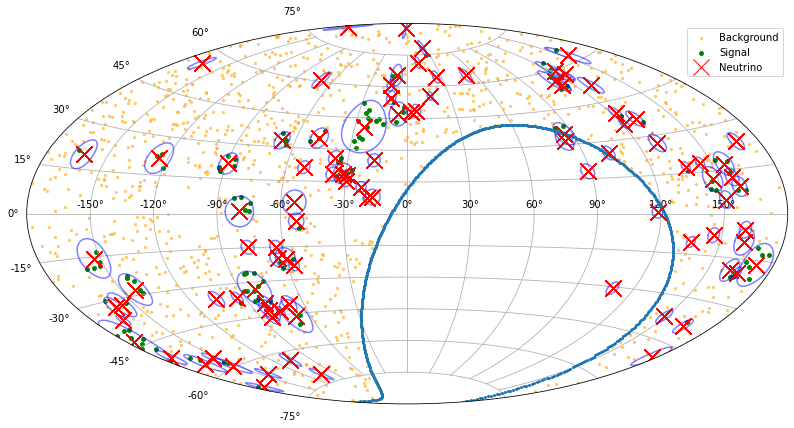

In [12]:
allN,NN2= RADEC_to_LoLaGal(df,RAN,DEN)
centerF,Flist=RADEC_to_LoLaGal(Present_sources,RA,DE)
fLon=lambda x: x.Lon
fLat=lambda x: x.Lat

rad_rad=[]
matchedNeu=[]
signal=[]
idN=[]
idd=[]
doubles=[]
for i in range(len(df)):
    
    arcmin_to_deg=0.0166667

    b =2+arcmin_to_deg*ErrorDir[i]
#     b =2
    rad_rad.append(np.deg2rad(b))
    

phi = np.linspace(0, 2.*np.pi,100 )#5 or more points
xh = np.asarray(list(map(lambda x: x.Lon,Flist)))
yh = np.asarray(list(map(lambda x: x.Lat,Flist)))
gx = list(map(fLon,NN2))
gy = list(map(fLat,NN2))

#Finding which sources belong to ON or OFF class
#Is the source inside the 'spatial error in detection circle' of the neutrino?
for kk in range(0,len(df)):

    m = rad_rad[kk] 

    for i in range(len(Present_sources)):

        #put condition on x and y to find closest point to gamma ray source ,
#         then to compare distances from circle point to neutrino (NN2) and the sources to neutrino (nn2)
        idN.append(kk)
        gg = np.sqrt((gx[kk]-xh[i])**2 + (gy[kk]-yh[i])**2)
        if gg<m and i not in idd: #second condition is to avoid double counting of ON source due to intersecting error detection circles
#             idN.append(kk)
            idd.append(i)
            doubles.append([kk,i])
            



rad_rad_filtered=[]

#
for i in range(len(idN)):
    a = idN[i]
    rad_rad_filtered.append(rad_rad[a])

p=np.arange(len(Present_sources))

#Array of indices of signal and background sources 
signal=idd
background=np.delete(p,idd)
matchedNeu=idN


fig1 = plt.figure(figsize=(15,7))
ax1 = fig1.add_subplot(111, projection="aitoff")
# ax1 = fig1.add_subplot(111) 


   
    
for i in range(0,len(df)):
    ##Drawing "regular polygons/circles" on the surface (is that an alternative way of selecting signals?)
    phi = np.linspace(0, 2.*np.pi,1000 )#5 or more points
    m = rad_rad[i]
    x = fLon(NN2[i]) + m*np.cos(phi)
    y = fLat(NN2[i]) + m*np.sin(phi)
    ax1.plot(-x, y, color="b", alpha=0.5)

#Get coordinates of OFF and ON sources
bkkx = np.asarray(list(map(lambda x: x.Lon,Flist)))[background]
bkky=np.asarray(list(map(lambda x: x.Lat,Flist)))[background]
sgx= np.asarray(list(map(lambda x: x.Lon,Flist)))[signal]
sgy = np.asarray(list(map(lambda x: x.Lat,Flist)))[signal]
bkkx=-bkkx
sgx=-sgx
gx = list(map(fLon,NN2[idN]))
gy=list(map(fLat,NN2[idN]))

for i in range(len(gx)):
    gx[i]=-gx[i]


#Filtering any sources in the Icecube Blind zone    
idx=[] 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for i in range(len(bkky)):
    a=find_nearest(-purgedX,bkkx[i])
    b = purgedY[a]
    if bkky[i]<b : # and bky[i]>min(purgedY):
        idx.append(i)
        
# bkkx=np.delete(bkkx,idx)
# bkky=np.delete(bkky,idx)

# #Make the 'aitoff' projection
ax1.scatter(bkkx, bkky,c='orange', s=5, alpha=0.5,label="Background")
ax1.scatter(sgx, sgy,c='green', s=15,alpha=1,label="Signal")
ax1.plot(-purgedX,purgedY,'o', markersize=2)
ax1.grid()
ax1.plot(gx, gy, 'rx', markersize=16, alpha=0.99,label='Neutrino')
ax1.legend();

In [13]:
print("Number of ON time series :",len(sgx))
print("Number of OFF time series :",len(bkkx))

Number of ON time series : 123
Number of OFF time series : 1019


In [14]:
ON=[]
OFF=[]
#Fill arrays with names of OFF and ON sources
for i in range(len(signal)):
    a=signal[i]
    ON.append(Present_sources[a])
for i in range(len(signal)):
    ON[i]=ON[i].replace('4FGL ','4FGL')  
    
for i in range(len(background)):
    a=background[i]
    OFF.append(Present_sources[a])
for i in range(len(signal)):
    OFF[i]=OFF[i].replace('4FGL ','4FGL')      


In [15]:
#Data location
import shutil

#Root directory of light curves - raw data
path_of_the_directory= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/Interpolated data/"

data_files = []
file_names = []

#Folder to save in separated files the OFF and ON time series
Saving_Folder_adress_ON= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/ON_data/"
Saving_Folder_adress_OFF= "C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/OFF_data/"


#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(path_of_the_directory):
    f = os.path.join(path_of_the_directory,filename)
    if os.path.isfile(f):
        data_files.append(f)
        file_names.append(filename)
 
for i in range(len(signal)):

    gg=signal[i]
    dest=Saving_Folder_adress_ON+ON[i]+'.csv'
    source=path_of_the_directory+file_names[gg]
    shutil.copyfile(source,dest)



for i in range(len(background)):
    
    gg=background[i]
    dest1=Saving_Folder_adress_OFF+OFF[i]+'.csv'
    source1=path_of_the_directory+file_names[gg]
    shutil.copyfile(source1,dest1)

        
